# Data Science - Laboratorio 5
## Minería de Texto: Clasificación de tweets 
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -

## Librerias

NOTA: Importante tener el Token de la API en el folder `C:\Users\<Windows-username>\.kaggle\kaggle.json`

Para una guia mas detallada o si tiene otro sistema dirigase a: https://www.kaggle.com/docs/api#getting-started-installation-&-authentication 

Asimismo puede visitar la documentacion oficial de la API: https://github.com/Kaggle/kaggle-api/tree/main/docs#api-credentials

In [1]:
# Kaggle API
import kaggle
from kaggle.rest import ApiException

# Operaciones con archivos
import os
import zipfile

# Operaciones con datos
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de Dataset

### Descargar el archivo con Kaggle

Puede omitir esta celda si decide descargar los archivos manualmente desde https://www.kaggle.com/c/nlp-getting-started/data

In [2]:
# Autenticación con Kaggle API
kaggle.api.authenticate()

# Definir competencia y directorio de descarga
competition_name = 'nlp-getting-started'
target_path = 'data'

# Verificar si existen archivos descargados previamente
if  not os.path.exists(f"{target_path}/train.csv") and not os.path.exists(f"{target_path}/test.csv"):
    # Descargar archivos de la competencia
    try:
        kaggle.api.competition_download_files(competition='nlp-getting-started',
                                            path='data',
                                            quiet=False,
                                            force=False)
        
        print(f"EXITO: Archivos descargados en '{target_path}'")

    except ApiException as e:
        print(f"ERROR al llamar KaggleApi -> competition_download \n\t{e}")
        print("Puede que necesite aceptar las reglas de la competencia en https://www.kaggle.com/c/nlp-getting-started/rules")
else:
    print("AVISO: Se encontraron archivos descargados previamente")
    print(f"\tSi desea descargar nuevamente los archivos, elimine '{target_path}/{competition_name}.zip'")

AVISO: Se encontraron archivos descargados previamente
	Si desea descargar nuevamente los archivos, elimine 'data/nlp-getting-started.zip'


### Descomprimir el Zip

Puede omitir esta celda si ya tiene los archivos descomprimidos

In [3]:
# Verificar si ya se descomprimieron los archivos .zip previamente
if  os.path.exists(f"{target_path}/train.csv") and os.path.exists(f"{target_path}/test.csv"):
    print("AVISO: Se encontraron archivos descargados previamente")
    print("\tOmitiendo descompresión de archivos .zip")

# Descomprimir archivos .zip
else:
    try:
        # Verificar si se descargó un archivo .zip y descomprimirlo
        if os.path.exists(f"{target_path}/{competition_name}.zip"):
            # Descomprimir archivo .zip
            with zipfile.ZipFile(f'{target_path}/{competition_name}.zip', 'r') as zip_ref:
                zip_ref.extractall(target_path)

            # Eliminar archivo .zip
            os.remove(f'{target_path}/{competition_name}.zip')
            os.remove(f'{target_path}/sample_submission.csv')
            print(f"EXITO: Archivo .zip descomprimido en '{target_path}'")
        else:
            raise Exception(f"No se encontró archivo .zip en '{target_path}'")

    except Exception as e:
        print(f"ERROR al descomprimir archivo .zip \n\t{e}")

AVISO: Se encontraron archivos descargados previamente
	Omitiendo descompresión de archivos .zip


### Generar dataframes

In [4]:
# Cargar archivos en DataFrames
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

## Comprensión Inicial

### Información General del Dataset

In [5]:
def get_DF_info(df):
    """
    Función que genera un dataframe con información sobre las columnas de un dataframe dado.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        
    Returns:
        None
    """
    # Crear un dataframe con la información de las columnas    
    info = pd.DataFrame({
        'Nombre Columna': df.columns,
        'Tipo de Dato': df.dtypes,
        'Valores Nulos (%)': (df.isnull().sum() * 100 / df.shape[0]).round(2),
        'Valores Únicos': df.nunique(),
        'Valores Duplicados': df.duplicated().sum()
    }).reset_index(drop=True)

    # Mostrar la informacion
    print(f"\nEl dataframe tiene {df.shape[0]} filas (registros) y {df.shape[1]} columnas (variables)\n")
    display(info)

In [6]:
print(f"Informacion del dataset: train.csv")
get_DF_info(df=train_df)

Informacion del dataset: train.csv

El dataframe tiene 7613 filas (registros) y 5 columnas (variables)



,Nombre Columna,Tipo de Dato,Valores Nulos (%),Valores Únicos,Valores Duplicados
0,id,int64,0.00,7613,0
1,keyword,object,0.80,221,0
2,location,object,33.27,3341,0
3,text,object,0.00,7503,0
4,target,int64,0.00,2,0


Como era de esperarse la variable `id` tiene un valor diferente por cada registro, por lo tanto no es relevante para esta práctica.

La variable objetivo `target` unicamente tiene 2 valores.

El conjunto de datos de entrenamiento tiene 2 variables que presentan valores nulos:
- `keyword`: Apenas un 0.8% de los registros totales son nulos.
- `location`: Mas del 33% de los registros totales son nulos.

Por lo tanto sera necesario analizar con detenimiento como manejar estas variables.

### Visualizar Dataframe

In [7]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Identificación de Variables

- `id` - Un identificador unico para cada tweet.
- `text` - El texto del tweet.
- `location` - La ubicación desde donde fue enviado el tweet.
- `keyword` - Una palabre clave del tweet.
- `target` - Etiqueta que denota si un tweet es sobre un desastre real o no

## Preprocesamiento y Limpieza

### Valores Nulos

#### Verificación valores nulos

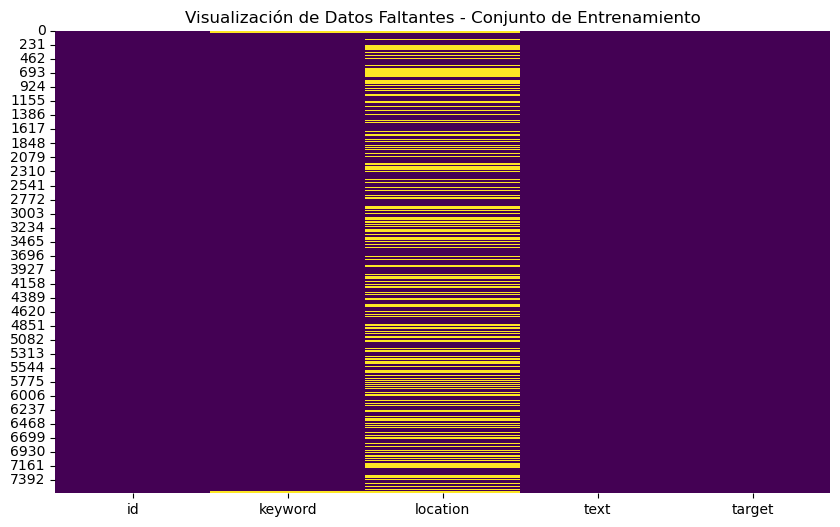

In [8]:
# Visualización de los datos faltantes en el conjunto de entrenamiento
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis")
plt.title("Visualización de Datos Faltantes - Conjunto de Entrenamiento")
plt.show()

Ese gráfico muestra que son muy pocos datos nulos en la variable `keyword`, sin embargo para la variable `location` si es mas visible la falta de datos corroborando que hay mas del 30% de datos nulos.

#### Análisis de Impacto de nulos

In [9]:
# Contar y calcular el porcentaje de registros conservados después de la eliminación de nulos
# Total de registros inicial
initial_count = train_df.shape[0]

# Eliminación de registros con valores nulos en keyword o location
dropna_keyword = train_df.dropna(subset=['keyword'])
dropna_location = train_df.dropna(subset=['location'])
dropna_both = train_df.dropna()

# Eliminación de registros con nulos en keyword, location, y ambos
dropna_keyword_count = dropna_keyword.shape[0]
dropna_location_count = dropna_location.shape[0]
dropna_both_count = dropna_both.shape[0]

# Cálculo de porcentajes conservados
dropna_keyword_pct = (dropna_keyword_count / initial_count) * 100
dropna_location_pct = (dropna_location_count / initial_count) * 100
dropna_both_pct = (dropna_both_count / initial_count) * 100

# Resultados del análisis
simplified_impact_analysis = pd.DataFrame({
    'Escenario': ['Original', 'Eliminando nulos de (keyword)', 'Eliminando nulos de (location)', 'Eliminando todos los nulos'],
    'Conteo': [initial_count, dropna_keyword_count, dropna_location_count, dropna_both_count],
    'Porcentaje conservado (%)': [100, dropna_keyword_pct, dropna_location_pct, dropna_both_pct]
})

display(simplified_impact_analysis)

,Escenario,Conteo,Porcentaje conservado (%)
0,Original,7613,100.000000
1,Eliminando nulos de (keyword),7552,99.198739
2,Eliminando nulos de (location),5080,66.727965
3,Eliminando todos los nulos,5080,66.727965


Estos resultados muestran que eliminar los registros nulos tiene un impacto significativo en el tamaño del conjunto de datos. Al eliminar los nulos de `location` desafortunadamente solo se convervan el 66% de los datos originales. Por lo tanto se ha decidido eliminar la variable ya que la imputación de valores no es una alternativa recomendable para este caso.

Por otro lado eliminar los registros nulos de `keyword` tienen un impacto de menos del 1%, por lo que es preferible preder ese ~1% que perder una variable entera con palabras clave de los tweets.

#### Manejo de Nulos

In [10]:
# Eliminar variable 'location'
train_df.drop(columns=['location'], inplace=True)

# Eliminar registros con valores nulos en 'keyword'
train_df.dropna(subset=['keyword'], inplace=True)

# Verificar si se eliminaron los registros con valores nulos
print("Datos faltantes en el conjunto de entrenamiento:")
print(train_df.isnull().sum())

Datos faltantes en el conjunto de entrenamiento:
id         0
keyword    0
text       0
target     0
dtype: int64
